# TD learning; the agent that can see
# Remember to check the number of samples for alpha and beta

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import seaborn as sns
from sklearn.metrics import confusion_matrix
np.random.seed(42)
from joblib import Parallel, delayed
import matplotlib.tri as tri
import matplotlib.colors as mcolors
from scipy.interpolate import griddata
from scipy.interpolate import RBFInterpolator
import matplotlib.ticker as mticker


In [8]:
folder_path = 'data_risk_added'
dataframes = [pd.read_excel(os.path.join(folder_path, file)) for file in os.listdir(folder_path) if file.endswith('.xlsx')]

n_participant = len(dataframes)
print(f"there are {n_participant} participants.")


output_dir = "11_RL_agent_TDlearn_output"
os.makedirs(output_dir, exist_ok=True)



there are 31 participants.


# policy initilization for the model
now I need to find the prior policy amounts. for that I am going to put the percentage of downarrow and up arrow for each distribution.

In [9]:
df_combined = pd.concat(dataframes, ignore_index=True)
df_combined = df_combined[df_combined['outcome'].str.lower() != 'na']  

count_df = df_combined.pivot_table(index="distribution", columns="choice", aggfunc="size", fill_value=0)
policy_initialization_df = count_df.div(count_df.sum(axis=1), axis=0)
policy_initialization_df

choice,arrowdown,arrowup
distribution,,
high,0.462007,0.537993
low,0.555556,0.444444
uniform,0.498925,0.501075


In [10]:
actions = { "arrowdown": 0, "arrowup": 1}
distributions_map = { "uniform": 0, "low": 1,  "high": 2}

policy_table = policy_initialization_df.rename(index=distributions_map, columns=actions).sort_index().to_numpy()

Q_table_init = np.random.normal(0, 0.1, (len(distributions_map), len(actions)))


# having a q-table based on the policies
Q_table_init = policy_table * np.mean(Q_table_init) 
Q_table = Q_table_init.copy()

# having a q-table that starts with 0!
# Q_table = np.zeros((len(distributions_map), len(actions)))  # 3 distributions × 2 actions


In [11]:
def softmax(Q_values, beta):    
    # this part subtracts the maximum q-value in each row it means each state to improve numerical stability.
    # because exxponentials of large numbers can lead to overflow errors, so shifting q-values avoids this problem.
    
    Q_shifted = Q_values - np.max(Q_values, axis=1, keepdims=True)
    exps = np.exp(beta * Q_shifted)
    sums = np.sum(exps, axis=1, keepdims=True)
    new_probs = exps / sums

    return new_probs





def train_rescorla_wagner(df, alpha, beta , Q_init=None):
    if Q_init is None:
        Q_init = Q_table.copy()
    Q_values = Q_init.copy()
    
    q_value_pairs = []
    choices = []
    predicted_probs = []
    distributions = []
    
    for _, row in df.iterrows():
        action = actions[row["choice"]] 
        distribution = distributions_map[row["distribution"]] 
        reward = 0.5 if row["outcome"] == "win" else -0.5
        
        probs = softmax(Q_values, beta)
        predicted_probs.append(probs[distribution][action])
        
        prediction_error = reward - Q_values[distribution][action]
        Q_values[distribution][action] += alpha * prediction_error
        
        q_value_pairs.append(Q_values.copy())
        choices.append(action)
        distributions.append(distribution)
        

    return np.array(q_value_pairs), np.array(choices), np.array(predicted_probs), np.array(distributions)

# this is for the sake of parallel computing
def compute_log_likelihood(alpha, beta, df_all, Q_table):
    Q_init_participant = Q_table.copy()
    q_values, choices, predicted_probs, distributions = train_rescorla_wagner(df_all, alpha, beta, Q_init=Q_init_participant)
    
    predicted_probs = np.clip(predicted_probs, 1e-6, 1)  # prevent log(0)
    log_likelihood = np.sum(np.log(predicted_probs))
    
    return (alpha, beta, log_likelihood)



saved: 11_RL_agent_TDlearn_output\plot_0.pdf
saved: 11_RL_agent_TDlearn_output\plot_1.pdf
saved: 11_RL_agent_TDlearn_output\plot_2.pdf
saved: 11_RL_agent_TDlearn_output\plot_3.pdf


KeyboardInterrupt: 

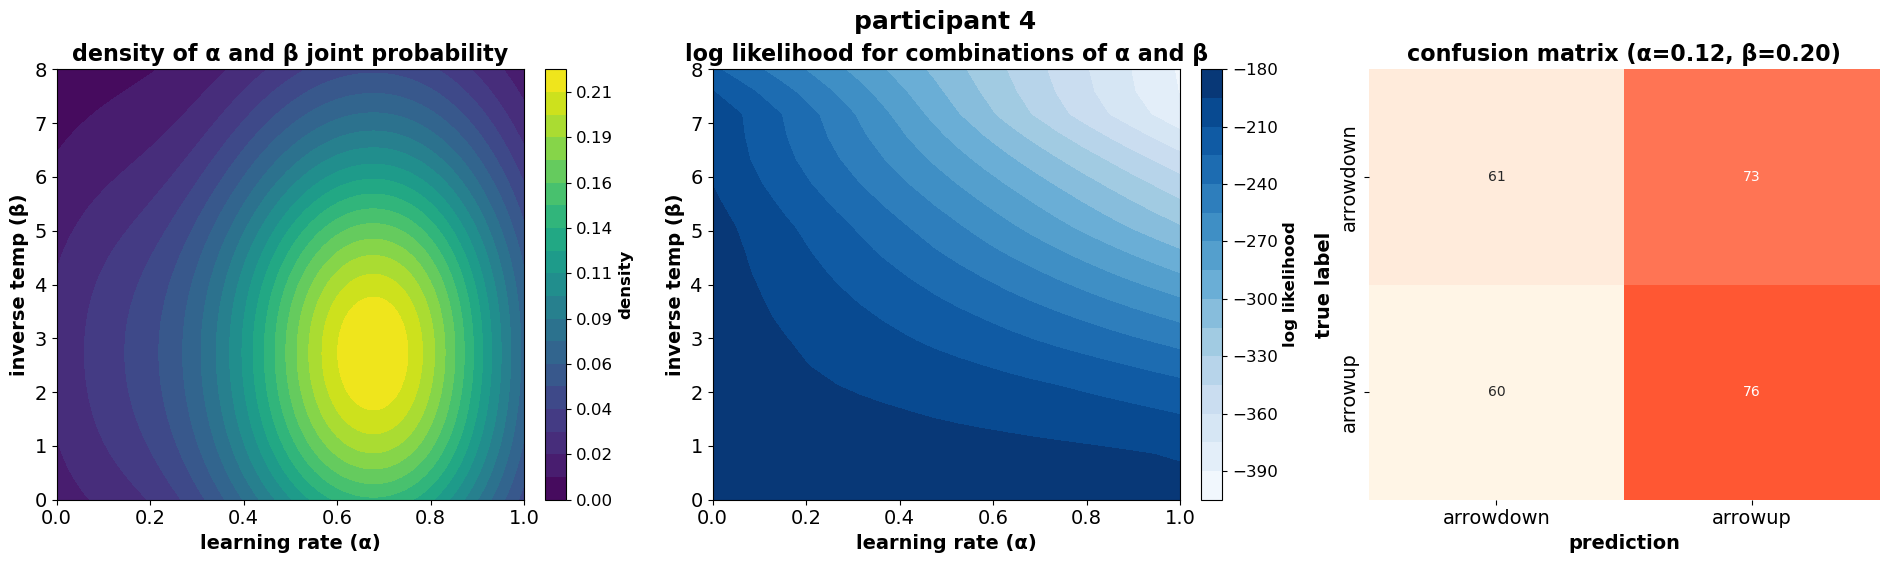

In [12]:
BIC_models = []
for idx, df_all in enumerate(dataframes):
    
    df_all = df_all[df_all['outcome'].str.lower() != 'na']  

    num_of_samples = 10
    # num_of_samples = 1000
    alpha_min = 0
    alpha_max = 1
    beta_min = 0
    beta_max  = 8
    alpha_samples = np.random.uniform(alpha_min, alpha_max, num_of_samples) 
    beta_samples = np.random.uniform(beta_min, beta_max, num_of_samples)  
    
    Q_init_participant = Q_table.copy()

    best_alpha, best_beta = None, None
    best_log_likelihood = -np.inf


    alpha_beta_log_likelihood = {}


    # finding alpha beta in parallel way
    results = Parallel(n_jobs=-1)(delayed(compute_log_likelihood)(alpha, beta, df_all, Q_table) 
                                for alpha in alpha_samples for beta in beta_samples)


    alpha_beta_log_likelihood = {}
    best_log_likelihood = -np.inf
    best_alpha, best_beta = None, None

    for alpha, beta, log_likelihood in results:
        alpha_beta_log_likelihood[(alpha, beta)] = log_likelihood
        if log_likelihood > best_log_likelihood:
            best_log_likelihood = log_likelihood
            best_alpha, best_beta = alpha, beta



    results_df = pd.DataFrame(alpha_beta_log_likelihood.keys(), columns=["alpha", "beta"])
    results_df["log_likelihood"] = alpha_beta_log_likelihood.values()

    #  model prediction 
    
    q_values, choices, predicted_probs, distributions = train_rescorla_wagner(df_all, best_alpha, best_beta, Q_init=Q_init_participant)
    # now we need to find out the predicted choices of the model:
    

    predicted_choices = []

    for trial in range(len(distributions)):  
        if q_values[trial][distributions[trial]][actions["arrowup"]] > q_values[trial][distributions[trial]][actions["arrowdown"]]:
            predicted_choices.append(1)
        else:
            predicted_choices.append(0)

    
    
    # confusion matrix
    conf_matrix = confusion_matrix(choices, predicted_choices)
    
    # bayes information criterion
    n_trials = len(df_all)
    k = 2  # number of free parameters: alpha and beta
    BIC = k * np.log(n_trials) - 2 * best_log_likelihood
    
    BIC_models.append(BIC)
    ###########################################################################################
    ## visulization

 
    fig, axes = plt.subplots(1, 3, figsize=(19, 6))

    plots_smooth_level = 20

    # Density Plot (KDE)
    sns.kdeplot(
        x=results_df["alpha"], 
        y=results_df["beta"], 
        fill=True, 
        cmap="viridis", 
        ax=axes[0], 
        bw_adjust=1.8,  # Increase for smoother density
        levels=plots_smooth_level,  # More contour levels
        thresh=0  # Ensure density is plotted across all values
    )
    mappable = axes[0].collections[0]
    cbar = fig.colorbar(mappable, ax=axes[0], label="density", fraction=0.046, pad=0.04)  # Adjust size
    cbar.ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))  # 2 decimal places
    cbar.ax.set_ylabel("density", fontsize=12, fontweight='bold')
    cbar.ax.tick_params(labelsize=12)

    axes[0].set_xlim(alpha_min, alpha_max)
    axes[0].set_ylim(beta_min, beta_max)
    axes[0].set_xlabel("learning rate (α)", fontsize=14, fontweight='bold')
    axes[0].set_ylabel("inverse temp (β)", fontsize=14, fontweight='bold')
    axes[0].set_title("density of α and β joint probability", fontsize=16, fontweight='bold')
    axes[0].tick_params(axis='both', labelsize=14)

    # Log Likelihood Contour Plot
    alpha_extrapolated = np.linspace(alpha_min, alpha_max, plots_smooth_level)
    beta_extrapolated = np.linspace(beta_min, beta_max, plots_smooth_level)
    xi, yi = np.meshgrid(alpha_extrapolated, beta_extrapolated)

    # Using RBFInterpolator for smoother interpolation and extrapolation
    rbf_interpolator = RBFInterpolator(
        np.column_stack((results_df["alpha"], results_df["beta"])), 
        results_df["log_likelihood"], 
        smoothing=0.2  
    )
    zi = rbf_interpolator(np.column_stack((xi.ravel(), yi.ravel()))).reshape(xi.shape)
    contour = axes[1].contourf(xi, yi, zi, levels=plots_smooth_level, cmap="Blues")
    cbar = plt.colorbar(contour, ax=axes[1], label="log likelihood", fraction=0.046, pad=0.04)  # Adjust size
    cbar.ax.set_ylabel("log likelihood", fontsize=12, fontweight='bold')
    cbar.ax.tick_params(labelsize=12)

    axes[1].set_xlabel("learning rate (α)", fontsize=14, fontweight='bold')
    axes[1].set_ylabel("inverse temp (β)", fontsize=14, fontweight='bold')
    axes[1].set_title("log likelihood for combinations of α and β", fontsize=16, fontweight='bold')
    axes[1].tick_params(axis='both', labelsize=14)

    # Confusion Matrix
    heatmap_cmap_color = mcolors.LinearSegmentedColormap.from_list("warm_red", ["#fff5e6", "#ff5733"])
    sns.heatmap(
        conf_matrix, annot=True, fmt="d", cmap=heatmap_cmap_color,
        xticklabels=["arrowdown", "arrowup"], 
        yticklabels=["arrowdown", "arrowup"], 
        ax=axes[2], 
        cbar=False
    )

    axes[2].set_xlabel("prediction", fontsize=14, fontweight='bold')
    axes[2].set_ylabel("true label", fontsize=14, fontweight='bold')
    axes[2].set_title(f"confusion matrix (α={best_alpha:.2f}, β={best_beta:.2f})", fontsize=16, fontweight='bold')
    axes[2].tick_params(axis='both', labelsize=14)






    plt.tight_layout(rect=[0, 0, 1, 0.9]) 
    fig.suptitle(f'participant {idx}', fontsize=18, fontweight='bold', y=0.93)

    filename = os.path.join(output_dir, f"plot_{idx}.pdf")
    plt.savefig(filename, format='pdf')
    plt.close(fig)

    print(f"saved: {filename}")


# saving BIC_models to compare models:
file_path_BIC = os.path.join(output_dir, "BIC_models_see_colors.txt")

with open(file_path_BIC, "w") as file:
    for bic in BIC_models:
        file.write(f"{bic}\n")

print(f"BIC values saved to {file_path_BIC}")
